# Learning Tensorflow + Gating networks
Notebook to learn some tensorflow basics. Draws on this tutorial https://www.tensorflow.org/tutorials/quickstart/advanced
We use the MNIST dataset to predict images using neural nets in tensorflow.
We also do some experimentation with basic Mixtures of Experts (MoE) where we train a network to select between other networks. Here we use two neural nets - some pre-trained on (subsets of) the MNIST data and get the gating network to select a network for prediction.


In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

tf.random.set_seed(1234)

TensorFlow version: 2.13.0


## Data/Code Prep
Prepare the data and some code utils

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

In [3]:
## split training and test sets into two separate sets
# train one on 0..4, another on 5..9
x_train1 = x_train[y_train < 5]
y_train1 = y_train[y_train < 5]

x_train2 = x_train[y_train >= 5]
y_train2 = y_train[y_train >= 5]

x_test1 = x_test[y_test < 5]
y_test1 = y_test[y_test < 5]

x_test2 = x_test[y_test >= 5]
y_test2 = y_test[y_test >= 5]

In [4]:
### full dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)
).shuffle(10000).batch(32)


test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

### dataset with labels 0..4
train_ds1 = tf.data.Dataset.from_tensor_slices(
    (x_train1, y_train1)
).shuffle(10000).batch(32)


test_ds1 = tf.data.Dataset.from_tensor_slices((x_test1, y_test1)).batch(32)

### dataset with labels 5..9
train_ds2 = tf.data.Dataset.from_tensor_slices(
    (x_train2, y_train2)
).shuffle(10000).batch(32)


test_ds2 = tf.data.Dataset.from_tensor_slices((x_test2, y_test2)).batch(32)

#### Training utilities
train steps, loops and some special loss classes for the Mixture of Expert (MoE) Models.

In [5]:
def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):
    with tf.GradientTape() as tape:

        # training = True only needed if some layers behave differently during training than inference
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

def test_step(model, images, labels, loss_object, test_loss, test_accuracy):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

def train_loop(model, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 5):
    train_step_tf = tf.function(train_step)
    test_step_tf = tf.function(test_step)
    for epoch in range(epochs):

        # reset metrics at the start of the next epoch
        # like opimizer.zero_grad?
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        for images, labels in train_ds:
            train_step_tf(model, images, labels, loss_object, optimizer, train_loss, train_accuracy)

        for test_images, test_labels in test_ds:
            test_step_tf(model, test_images, test_labels, loss_object, test_loss, test_accuracy)

        print(
            f'Epoch {epoch + 1}',
            f'Loss: {train_loss.result()}',
            f'Accuracy: {train_accuracy.result()*100}',
            f'Test Loss: {test_loss.result()}',
            f'Test Accuracy: {test_accuracy.result() * 100}'
        )


class MoE_loss(tf.keras.losses.Loss):

    def __init__(self, name, loss_fn, shift = False, alpha = 1, beta = 1, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn = loss_fn
        self.shift = shift
        self.alpha = alpha
        self.beta = beta

    def __call__(self, y_true, y_pred):
        # outputted predictions as a tuple
        y_pred_m1 = y_pred[0]
        y_pred_m2 = y_pred[1]
        gv_m1 = y_pred[2]
        gv_m2 = y_pred[3]

        m1_loss = self.loss_fn(y_true, y_pred_m1, sample_weight=gv_m1)
        m2_loss = self.loss_fn(y_true, y_pred_m2, sample_weight=gv_m2)
        loss = m1_loss + m2_loss
    
        if self.shift:
            loss += self.alpha * (gv_m1 / (gv_m2 + 1.0e-8))**self.beta

        return tf.reduce_mean(loss)

class MoE_accuracy(tf.keras.metrics.Metric):
    def __init__(self, name, base_metric, **kwargs):
        super().__init__(**kwargs)
        self.base_metric = base_metric
        self.moe_acc = self.add_weight('moe_acc', initializer='zeros')
        # self.base_metric_val = -1
        
    def update_state(self, y_true, y_pred):
        """
        y_true are actual predictions
        y_pred is a tuple containing two separate model predictions and gating values
        """
        
        y_pred_m1 = y_pred[0]
        y_pred_m2 = y_pred[1]
        gv_m1 = y_pred[2]
        gv_m2 = y_pred[3]

        combined_predictions = tf.expand_dims(gv_m1, axis=-1) * y_pred_m1 +\
            tf.expand_dims(gv_m2, axis=-1)* y_pred_m2

        self.moe_acc.assign(self.base_metric(y_true, combined_predictions))

    def reset_states(self):
        self.base_metric.reset_states()
        self.moe_acc.assign(0)

    def result(self):
        return self.moe_acc



## Base models
Train three base models using labels 0..4, 5..9 and all labels.
We can combine these in later models and use as baseline of performance.

In [6]:
# build a tf.keras model
class TfModel(Model):

    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        # dense seems to be feed forward (makes sense)
        # also only output dimensions seem to be specified?
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)

    def call(self, x):

        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)



In [7]:
# specify loss metrics
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [8]:
# trained on labels 0..4
model1 = TfModel()
optimizer1 = tf.keras.optimizers.Adam(weight_decay=0.1)
train_loop(model1, train_ds1, test_ds1, optimizer1, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)
# model1.save_weights('./model1/model1.keras')

# trained on labels 5..9
model2 = TfModel()
optimizer2 = tf.keras.optimizers.Adam(weight_decay=0.1)
train_loop(model2, train_ds2, test_ds2, optimizer2, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)
# model2.save_weights('./model2/model2.keras')

# trained on all labels
model3 = TfModel()
optimizer3 = tf.keras.optimizers.Adam(weight_decay=0.1)
train_loop(model3, train_ds, test_ds, optimizer3, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)

Epoch 1 Loss: 0.07128338515758514 Accuracy: 97.87226867675781 Test Loss: 0.022869670763611794 Test Accuracy: 99.31893157958984
Epoch 2 Loss: 0.01898830756545067 Accuracy: 99.39534759521484 Test Loss: 0.014438626356422901 Test Accuracy: 99.5718994140625
Epoch 3 Loss: 0.009774205274879932 Accuracy: 99.7221908569336 Test Loss: 0.013802018947899342 Test Accuracy: 99.49406433105469
Epoch 1 Loss: 0.1169455498456955 Accuracy: 96.2794189453125 Test Loss: 0.05509422346949577 Test Accuracy: 98.14852905273438
Epoch 2 Loss: 0.0369575135409832 Accuracy: 98.80628967285156 Test Loss: 0.0514032356441021 Test Accuracy: 98.354248046875
Epoch 3 Loss: 0.022085517644882202 Accuracy: 99.28581237792969 Test Loss: 0.03851978853344917 Test Accuracy: 98.82740020751953
Epoch 1 Loss: 0.13997508585453033 Accuracy: 95.74333190917969 Test Loss: 0.06943432986736298 Test Accuracy: 97.79999542236328
Epoch 2 Loss: 0.049521446228027344 Accuracy: 98.54666900634766 Test Loss: 0.05342554301023483 Test Accuracy: 98.259994506

## Combined Models
Here we have a model with a gating function that chooses the best network. Its not quite a true MoE as we combine the outputs before calculating the loss. My understanding is that this will result in the learnt gating assignment being a linear combination of each of the experts, rather than assigning an observation to a single expert.

In [9]:
class CombinedModel(Model):
    def __init__(self, model1, model2, model1_trainable = False, model2_trainable = False, input_shape = (1,28,28,1)):
        super().__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.dc1 = Dense(2, activation='softmax')

        # clone the models
        self.model1 = tf.keras.models.clone_model(model1)
        self.model1.build(input_shape)
        self.model1.set_weights(model1.get_weights())
        self.model1.trainable = model1_trainable

        self.model2 = tf.keras.models.clone_model(model2)
        self.model2.build(input_shape)
        self.model2.set_weights(model2.get_weights())
        self.model2.trainable = model2_trainable

    
    def _get_gating_values(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        return self.dc1(x)


    def call(self, x):
        # get frozen model outputs
        m1 = self.model1(x)
        m2 = self.model2(x)
        stacked_models = tf.stack([m1, m2], axis=1)

        # calculate gating values
        gating_values = self._get_gating_values(x)
        
        # combine models with gating values
        gating_values = tf.expand_dims(gating_values, axis = -1)
        x = tf.matmul(gating_values, stacked_models, transpose_a=True)
        return tf.squeeze(x, axis = 1)


In [10]:
# train with both model1, model2 frozen - should see performance that averages model1/model2
optimizer = tf.keras.optimizers.Adam()
combined_model1 = CombinedModel(model1, model2)
train_loop(combined_model1, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)

Epoch 1 Loss: 0.09413594007492065 Accuracy: 97.53166198730469 Test Loss: 0.09076125919818878 Test Accuracy: 97.47000122070312
Epoch 2 Loss: 0.06708226352930069 Accuracy: 98.29499816894531 Test Loss: 0.08732044696807861 Test Accuracy: 97.52999877929688
Epoch 3 Loss: 0.05749852955341339 Accuracy: 98.5816650390625 Test Loss: 0.08878131210803986 Test Accuracy: 97.43999481201172


In [11]:
# # train with model2 unfrozen - enables it to fit to unseen labels - hypothesise that eventually the model will favor model2 for everything
# optimizer = tf.keras.optimizers.Adam()
# combined_model2 = CombinedModel(model1, model2, model2_trainable=True)
# train_loop(combined_model2, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)

In [12]:
# train with model2 unfrozen - enables it to fit to unseen labels - hypothesise that eventually the model will favor model2 for everything
### TRY THIS ONE WITH 15 ITERS - what happens to the gating values? shift completely to model2? 3 epochs doesn't seem enough
# also - have you  actually implemented an MoE correctly - both networks should output their values, then their errors should be proportionally combined
optimizer = tf.keras.optimizers.Adam()
combined_model2 = CombinedModel(model1, model2, model2_trainable=True)
train_loop(combined_model2, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 15)

Epoch 1 Loss: 0.06665972620248795 Accuracy: 98.01166534423828 Test Loss: 0.05646035447716713 Test Accuracy: 98.0199966430664
Epoch 2 Loss: 0.029113639146089554 Accuracy: 99.08000183105469 Test Loss: 0.052894286811351776 Test Accuracy: 98.29000091552734
Epoch 3 Loss: 0.01659226417541504 Accuracy: 99.51666259765625 Test Loss: 0.0690680667757988 Test Accuracy: 97.82999420166016
Epoch 4 Loss: 0.010496970266103745 Accuracy: 99.68000030517578 Test Loss: 0.06504194438457489 Test Accuracy: 98.22999572753906
Epoch 5 Loss: 0.007205749861896038 Accuracy: 99.788330078125 Test Loss: 0.06465334445238113 Test Accuracy: 98.18999481201172
Epoch 6 Loss: 0.005510952789336443 Accuracy: 99.83999633789062 Test Loss: 0.0605790875852108 Test Accuracy: 98.36000061035156
Epoch 7 Loss: 0.004736178554594517 Accuracy: 99.85166931152344 Test Loss: 0.06490618735551834 Test Accuracy: 98.38999938964844
Epoch 8 Loss: 0.0030651690904051065 Accuracy: 99.90333557128906 Test Loss: 0.06360330432653427 Test Accuracy: 98.5299

In [13]:
random_init_model = TfModel()
random_init_model.build(x_train.shape)

# train with model3 - trained on all labels, but frozen, and a randomly initialised model - hypothesise that randomly initialised model may not learn due to good performance from model3
optimizer = tf.keras.optimizers.Adam()
combined_model3 = CombinedModel(model3, random_init_model, model2_trainable=True)
train_loop(combined_model3, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)

Epoch 1 Loss: 0.02035585045814514 Accuracy: 99.3933334350586 Test Loss: 0.05744265019893646 Test Accuracy: 98.18000030517578
Epoch 2 Loss: 0.020313067361712456 Accuracy: 99.39167022705078 Test Loss: 0.05744265019893646 Test Accuracy: 98.18000030517578
Epoch 3 Loss: 0.02031308226287365 Accuracy: 99.39167022705078 Test Loss: 0.05744265019893646 Test Accuracy: 98.18000030517578


## MoE models
Here we use genuine MoE where the loss is calculated for each expert and then weighted proportionally. We add a shift penalty term as well which encourages the gating values to shift towards the unfrozen model - model 2. 

In [14]:
class MoE(Model):
    def __init__(self, model1, model2, model1_trainable = False, model2_trainable = False, input_shape = (1,28,28,1)):
        super().__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.dc1 = Dense(2, activation='softmax')

        # clone the models
        self.model1 = tf.keras.models.clone_model(model1)
        self.model1.build(input_shape)
        self.model1.set_weights(model1.get_weights())
        self.model1.trainable = model1_trainable

        self.model2 = tf.keras.models.clone_model(model2)
        self.model2.build(input_shape)
        self.model2.set_weights(model2.get_weights())
        self.model2.trainable = model2_trainable

    def _get_gating_values(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        return self.dc1(x)

    def call(self, x):
        # get frozen model outputs
        m1 = self.model1(x)
        m2 = self.model2(x)

        # calculate gating values
        gating_values = self._get_gating_values(x)
        return m1, m2, gating_values[:,0], gating_values[:,1]

    def predict(self, x):
        return self.combine_predictions(x)

    def combine_predictions(self, x):
        preds = self.call(x)
        y_pred_m1 = preds[0]
        y_pred_m2 = preds[1]
        gv_m1 = preds[2]
        gv_m2 = preds[3]

        combined_predictions = tf.expand_dims(gv_m1, axis=-1) * y_pred_m1 +\
            tf.expand_dims(gv_m2, axis=-1)* y_pred_m2

        return combined_predictions

In [15]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = MoE_accuracy(name='train_accuracy', base_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='base_train_acc'))#tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = MoE_accuracy(name='test_accuracy', base_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='base_test_acc'))

In [16]:
# specify loss metrics
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
loss_object = MoE_loss(name = 'moe_loss', loss_fn=loss_fn)


optimizer = tf.keras.optimizers.Adam()
MOE1 = MoE(model1, model2, model2_trainable=True)
train_loop(MOE1, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)

Epoch 1 Loss: 0.11945148557424545 Accuracy: 97.19667053222656 Test Loss: 0.05549458786845207 Test Accuracy: 98.15999603271484
Epoch 2 Loss: 0.030767980962991714 Accuracy: 99.05166625976562 Test Loss: 0.05110688880085945 Test Accuracy: 98.37999725341797
Epoch 3 Loss: 0.015287973918020725 Accuracy: 99.49333190917969 Test Loss: 0.06008131057024002 Test Accuracy: 98.19999694824219


In [17]:
# specify loss metrics
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
loss_object = MoE_loss(name = 'moe_loss', loss_fn=loss_fn, shift=True)


optimizer = tf.keras.optimizers.Adam()
MOE2 = MoE(model1, model2, model2_trainable=True)
train_loop(MOE2, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)

Epoch 1 Loss: 0.12029571086168289 Accuracy: 97.04666900634766 Test Loss: 0.056948110461235046 Test Accuracy: 98.1500015258789
Epoch 2 Loss: 0.029998792335391045 Accuracy: 99.11333465576172 Test Loss: 0.06374350935220718 Test Accuracy: 98.0199966430664
Epoch 3 Loss: 0.016801945865154266 Accuracy: 99.45500183105469 Test Loss: 0.059212956577539444 Test Accuracy: 98.15999603271484


In [18]:
# specify loss metrics
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
loss_object = MoE_loss(name = 'moe_loss', loss_fn=loss_fn, shift=True, beta =.05)


optimizer = tf.keras.optimizers.Adam()
MOE3 = MoE(model1, model2, model2_trainable=True)
train_loop(MOE3, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)

Epoch 1 Loss: nan Accuracy: 12.53166675567627 Test Loss: nan Test Accuracy: 9.800000190734863
Epoch 2 Loss: nan Accuracy: 9.87166690826416 Test Loss: nan Test Accuracy: 9.800000190734863
Epoch 3 Loss: nan Accuracy: 9.87166690826416 Test Loss: nan Test Accuracy: 9.800000190734863


In [19]:
# specify loss metrics
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
loss_object = MoE_loss(name = 'moe_loss', loss_fn=loss_fn)

# randomly initialise
random_init_model = TfModel()
random_init_model.build(x_train.shape)

optimizer = tf.keras.optimizers.Adam()
MOE4 = MoE(model3, random_init_model, model2_trainable=True)
train_loop(MOE4, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)

Epoch 1 Loss: 0.021456275135278702 Accuracy: 99.39167022705078 Test Loss: 0.0574428029358387 Test Accuracy: 98.18000030517578
Epoch 2 Loss: 0.020313158631324768 Accuracy: 99.39167022705078 Test Loss: 0.05744268745183945 Test Accuracy: 98.18000030517578
Epoch 3 Loss: 0.02031310461461544 Accuracy: 99.39167022705078 Test Loss: 0.05744265764951706 Test Accuracy: 98.18000030517578


In [20]:
# specify loss metrics
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
loss_object = MoE_loss(name = 'moe_loss', loss_fn=loss_fn, shift=True)

# randomly initialise
random_init_model = TfModel()
random_init_model.build(x_train.shape)

optimizer = tf.keras.optimizers.Adam()
MOE5 = MoE(model3, random_init_model, model2_trainable=True)
train_loop(MOE5, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)

Epoch 1 Loss: 0.12934459745883942 Accuracy: 96.29833221435547 Test Loss: 0.06014855578541756 Test Accuracy: 98.02999877929688
Epoch 2 Loss: 0.040795207023620605 Accuracy: 98.72666931152344 Test Loss: 0.054906997829675674 Test Accuracy: 98.06999969482422
Epoch 3 Loss: 0.020555436611175537 Accuracy: 99.33666229248047 Test Loss: 0.051003970205783844 Test Accuracy: 98.33999633789062


## Results
We can see below - when model 2 (model trained on 5..9) is fitted alongside a frozen model 1 (combined model 2) performance is best and model 2 improves its performance on the whole dataset significantly (increases from 48% acc to 82% acc)

Combined model 3 has a frozen network trained on the whole dataset, don't seem to update the randomly initialised model and gating values seem to exclusively focus on the 'right' network (i.e. the frozen one).

Comparing MoE 4 and MoE 5 is interesting - Both use model 3 as their frozen network with a randomly initialised unfrozen network. However, MoE 5 applies a shift penalty. The shift penalty does not seem to negatively impact performance (in fact MoE 5 has slightly better performance). Comparing the gating value plots below we see that MoE 4 uses the frozen network exclusively (model1 gating value of ~1) while MoE 5 uses the unfrozen learnt network exclusively. This seems to indicate that in cases where there is a frozen network with close to optimal performance, a shift penalty can over-come this while still retaining performance.
This works nicely for this dataset, but its also a very simple dataset to learn (takes a single epoch to get close to 100% accuracy).

In [21]:
def print_acc(model, model_name):
    acc = lambda y_pred, y_true: 100 *  float(tf.reduce_sum(tf.cast(tf.argmax(y_pred, axis=-1)==y_true, tf.int64)) / y_true.shape)
    preds = model.predict(x_test)
    print(
        f"{model_name}: {acc(preds, y_test):.3f}%"
    )

print_acc(model1, 'Model 1')
print_acc(model2, 'Model 2')
print_acc(model3, 'Model 3')
print_acc(combined_model1, 'Combined Model 1')
print_acc(combined_model2, 'Combined Model 2')
print_acc(combined_model2.model2, 'Combined Model 2 (Trained Model 2)')
print_acc(combined_model3, 'Combined Model 3')
print_acc(combined_model3.model2, 'Combined Model 3 (Trained random init model)')
print_acc(MOE1, 'MoE 1')
print_acc(MOE1.model2, 'MoE 1 (trained model 2)')
print_acc(MOE2, 'MoE 2 - with shift')
print_acc(MOE2.model2, 'MoE 2 - with shift (trained model 2)')
# print_acc(MOE3, 'MoE 3 - with shift and large beta')
# print_acc(MOE3.model2, 'MoE 3 - with shift and large beta (trained model 2)')
print_acc(MOE4, 'MoE 4')
print_acc(MOE4.model2, 'MoE 4 (Trained random init model)')
print_acc(MOE5, 'MoE 5 - with shift')
print_acc(MOE5.model2, 'MoE 5 - with shift (Trained random init model)')

313/313 [==============================] - 2s 6ms/step
Model 1: 51.130%
313/313 [==============================] - 2s 5ms/step
Model 2: 48.040%
313/313 [==============================] - 2s 6ms/step
Model 3: 98.180%
313/313 [==============================] - 3s 9ms/step
Combined Model 1: 97.440%
313/313 [==============================] - 3s 9ms/step
Combined Model 2: 98.360%
313/313 [==============================] - 2s 5ms/step
Combined Model 2 (Trained Model 2): 95.630%
313/313 [==============================] - 3s 8ms/step
Combined Model 3: 98.180%
313/313 [==============================] - 2s 5ms/step
Combined Model 3 (Trained random init model): 17.830%
MoE 1: 98.200%
313/313 [==============================] - 2s 6ms/step
MoE 1 (trained model 2): 98.200%
MoE 2 - with shift: 98.160%
313/313 [==============================] - 2s 5ms/step
MoE 2 - with shift (trained model 2): 98.160%
MoE 4: 98.180%
313/313 [==============================] - 2s 5ms/step
MoE 4 (Trained random init mode

In [22]:
def get_gating_values_by_result(model, x_test, y_test):
    preds = model.predict(x_test)
    gating_values = model._get_gating_values(x_test)

    df = pd.DataFrame(
        {
            'model1_share': tf.get_static_value(gating_values[:,0]),
            'model2_share': tf.get_static_value(gating_values[:,1]),
            'predicted_labels': tf.get_static_value(tf.argmax(preds, axis=-1)),
            'true_labels':y_test
            }
        )

    df.loc[:,'true_labels'] = pd.Categorical(df.loc[:, 'true_labels'])
    df.loc[:,'predicted_labels'] = pd.Categorical(df.loc[:, 'predicted_labels'])

    return df.melt(
        id_vars = ('true_labels', 'predicted_labels'),
        value_vars = ('model1_share', 'model2_share')
        )

def plot_gating_values_by_result(result_df):

    fig, ax = plt.subplots(1,2,figsize = (15, 7))
    ax = ax.flatten()

    sns.boxplot(data = result_df, x ='true_labels', y = 'value', hue='variable', ax = ax[0], showfliers = False)
    sns.boxplot(data = result_df, x ='predicted_labels', y = 'value', hue='variable', ax = ax[1], showfliers = False)
    plt.show();


 35/313 [==>...........................] - ETA: 1s

313/313 [==============================] - 3s 9ms/step


c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\cat

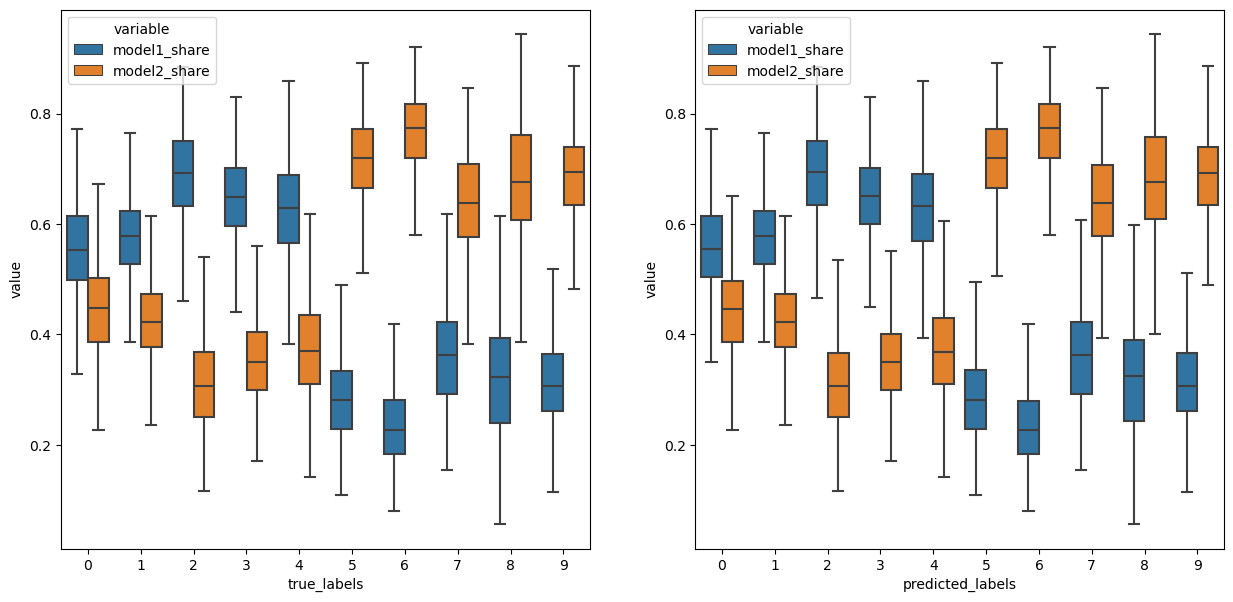

In [23]:
# combined model 1 - both experts frozen - can see that gating values assign to the appropriate expert
result_df = get_gating_values_by_result(combined_model1, x_test, y_test)
plot_gating_values_by_result(result_df)

 19/313 [>.............................] - ETA: 1s

313/313 [==============================] - 2s 8ms/step


c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\cat

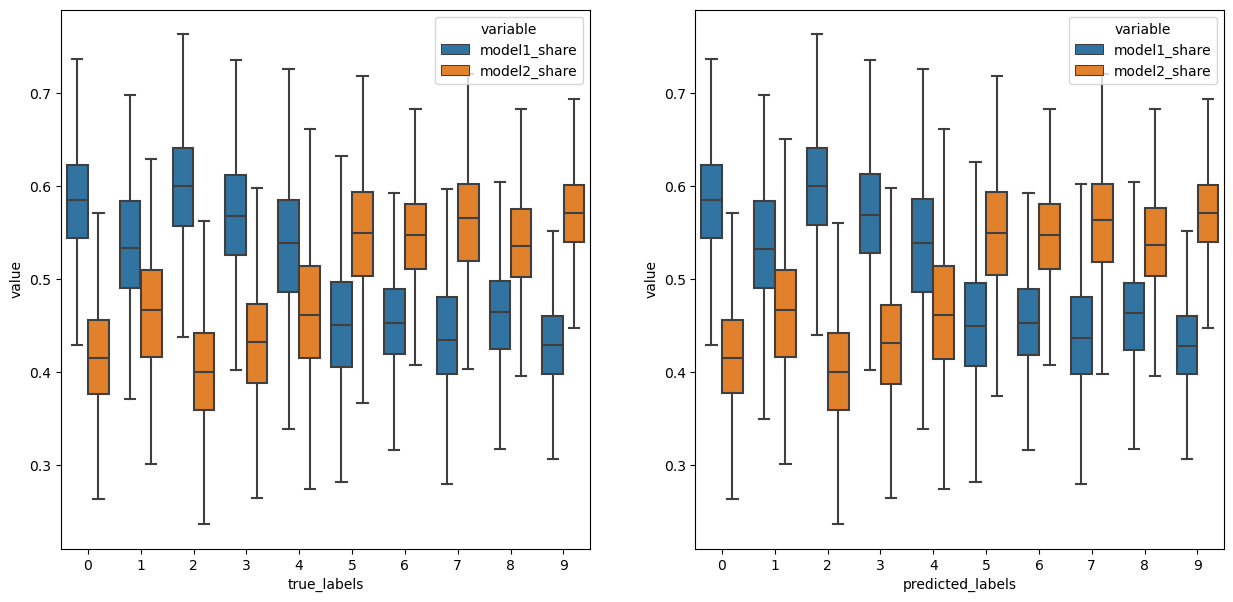

In [24]:
# model 2 (unfrozen) has gating values increase for labels 0..4 (compared to frozen version above) but gating values also decrease for model 2 for the labels it was originally trained on (5..9)
# perhaps due to the comparable performance of model 2 on 0..4 the gating network becomes less certain of proportional assignments?
result_df = get_gating_values_by_result(combined_model2, x_test, y_test)
plot_gating_values_by_result(result_df)

 18/313 [>.............................] - ETA: 1s

313/313 [==============================] - 3s 8ms/step


c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\cat

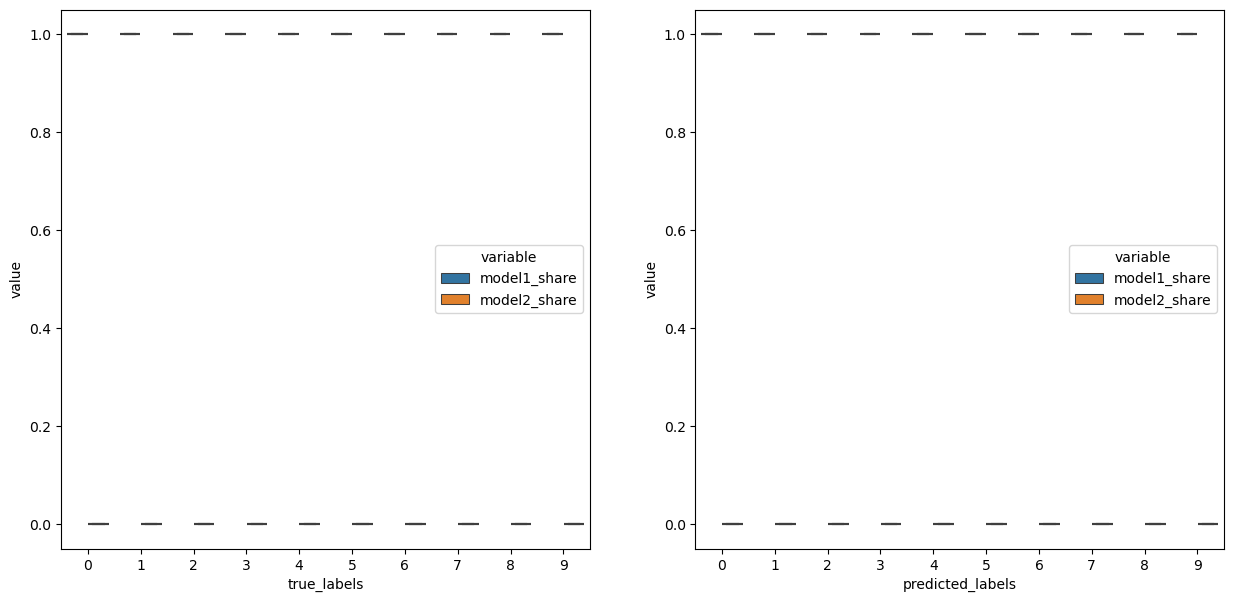

In [25]:
# combined model with frozen network trained on full dataset - gating values dont shift, everything is assigned to model 1 (i.e. the pre-trained network)
result_df = get_gating_values_by_result(combined_model3, x_test, y_test)
plot_gating_values_by_result(result_df)

c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\cat

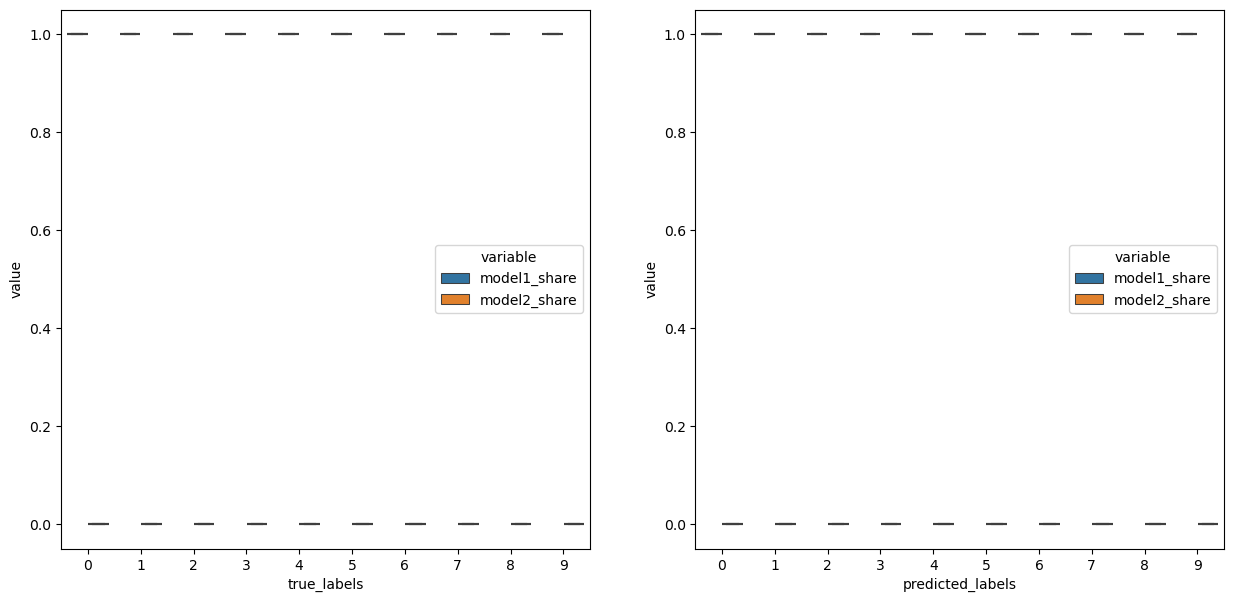

In [26]:
# as above - everything is assigned to model 1 - i.e. the frozen network trained on the entire dataset
result_df = get_gating_values_by_result(MOE4, x_test, y_test)
plot_gating_values_by_result(result_df)

c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\cat

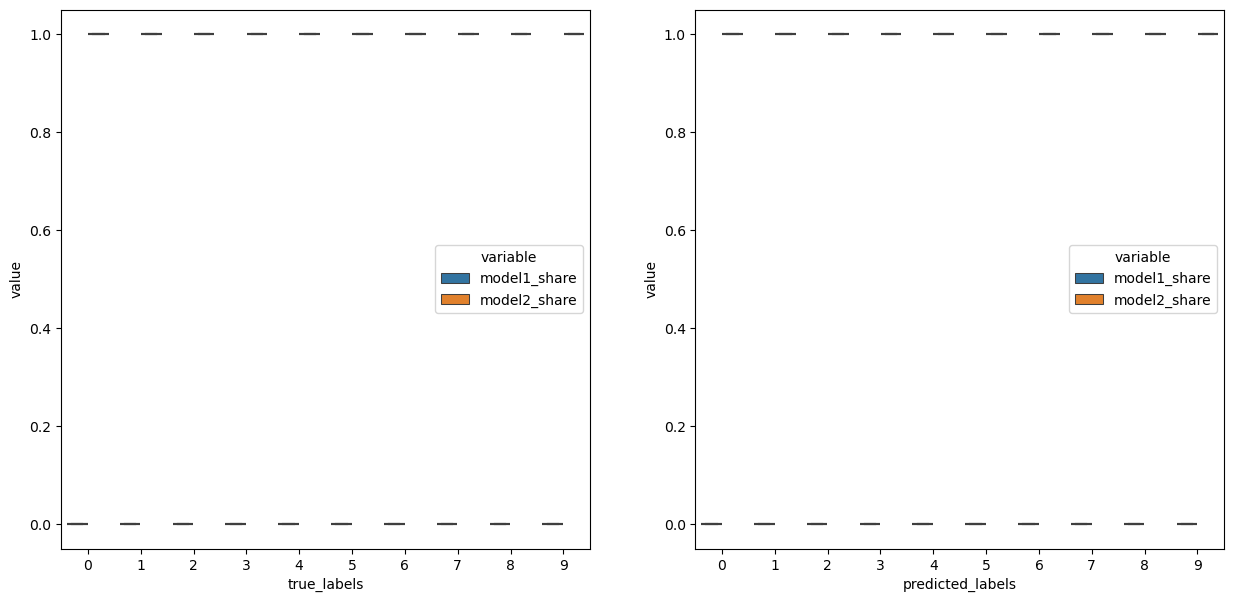

In [27]:
# but with switching parameter turned on, it does seem to switch to the randomly initialised network (model2)!!
result_df = get_gating_values_by_result(MOE5, x_test, y_test)
plot_gating_values_by_result(result_df)

tf.Tensor([[2.9574003e-11 1.0000000e+00]], shape=(1, 2), dtype=float32)


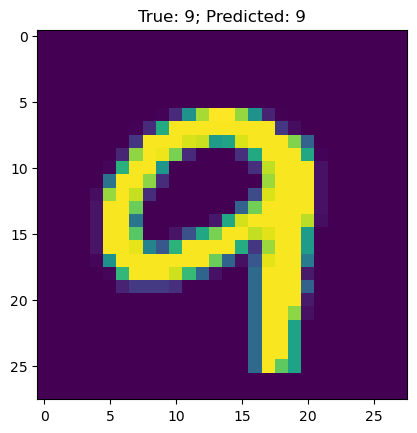

In [28]:
i = int(tf.random.uniform([1], minval=0, maxval=5000, dtype=tf.dtypes.int32))
_input = x_test[i][tf.newaxis,...]
plt.imshow(x_test[i]);
pred = tf.argmax(MOE5.predict(_input), axis=-1)[0]
gating_values = MOE5._get_gating_values(_input)
print(gating_values)
plt.title(f'True: {y_test[i]}; Predicted: {pred}')
plt.show()